In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt

DATADIR='../data'

In [4]:
# Absolute mortality by month
mbm = pd.read_csv(f'{DATADIR}/nhivs_deaths.csv')
# NH population by year
pop = pd.read_csv(f'{DATADIR}/nh_pop_macrotrends.csv')

mbm['Rate'] = mbm['Deaths'] / pop.loc[mbm['Year']-1995]['Population'].to_numpy()

# Considering "Shift years" from Aug 1 -> July 30 - drop leading and trailing incomplete years.
mbm_syear = mbm[7:7+25*12]
mbm_syear.index = range(0, 25*12)
# Calculate the rate for total deaths for each year - indexed by _ending_ year.
mby = pd.DataFrame()
for y in range(1995, 2020):
    mby.at[int(y-1995), 'Rate'] = mbm_syear['Rate'][(y - 1995) * 12 : (y - 1995 + 1) * 12].sum()
# Checksum
print(f"Total of: annual rates={mby['Rate'].sum()}; monthly rates={mbm_syear['Rate'].sum()}")

# Fit line from 2008/9 to 2018/19 (to predict 2020 from)
p_linefit, stats = np.polynomial.Polynomial.fit(range(0,11), mby['Rate'][13:-1], 1, full=True, window=(0,11), domain=(0,11))
p_d2009, p_m = p_linefit
p_line = [None for x in range(0,13)] + [p_d2009 + p_m * x for x in range(0,12)]
# Fit line from 2008/9 to 2019/20
linefit, stats = np.polynomial.Polynomial.fit(range(0,12), mby['Rate'][13:], 1, full=True, window=(0,12), domain=(0,12))
d2009, m = linefit
line = [None for x in range(0,13)] + [d2009 + m * x for x in range(0,12)]
# Envelope line capturing maximum values in predicted line, offset from p-line by max difference between data and line
pe_line = [None for x in range(0,13)] + [p_d2009 + max(mby['Rate'][13:-1] - line[13:-1]) + p_m * x for x in range(0,12)]

# Year-on-year change percentage
dl = mby['Rate'].to_numpy()
perc = np.divide(dl[1:25]-dl[0:24],dl[0:24])*100
perc = np.insert(perc, 0, 0)
print(mby*1000000)
print(perc)



Total of: annual rates=0.20307955038255704; monthly rates=0.20307955038255704
           Rate
0   7913.835778
1   8091.154186
2   8033.216419
3   7922.835655
4   7658.459596
5   7883.196261
6   7767.518238
7   7569.613252
8   7802.736068
9   7724.949162
10  7547.623069
11  7744.679175
12  7725.985638
13  7609.303548
14  7524.576295
15  8003.349246
16  7861.225479
17  8082.137343
18  8221.026540
19  8805.030232
20  8629.024108
21  9051.254786
22  9171.101314
23  9125.588605
24  9610.130388
[ 0.          2.24061268 -0.71606306 -1.3740544  -3.33688683  2.93448913
 -1.46740001 -2.54785351  3.07971897 -0.99691832 -2.29549852  2.61083661
 -0.24137265 -1.51025506 -1.11346923  6.36278952 -1.77580364  2.81014538
  1.71847113  7.10378064 -1.99892698  4.89314519  1.32408745 -0.4962622
  5.30970444]


In [8]:
# Plot monthly mortality
x = np.linspace(1, mbm_syear.shape[0], mbm_syear.shape[0])
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(x, mbm_syear['Rate']*1000000)
ax.set_xlabel('Year ending July 30, 1996-2020', fontsize=20)
ax.set_ylabel('Mortality rate / million', fontsize=20)
ax.set_title('NH all cause mortality rate by month', fontsize=20)
ax.set_xticks(range(0,300,12))
x = ax.set_xticklabels([f"{str(year)[2:]}" for year in range(1995, 2020)], fontsize=20)
y = ax.set_yticklabels([y for y in range (0, 900, 100)], fontsize=20)
ax.grid(linestyle='dotted')
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)
ax.set_xlim(right=300)


<ipython-input-8-8787a94890d6>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  y = ax.set_yticklabels([y for y in range (0, 900, 100)], fontsize=20)


(0.0, 300.0)

(0.0, 26.0)

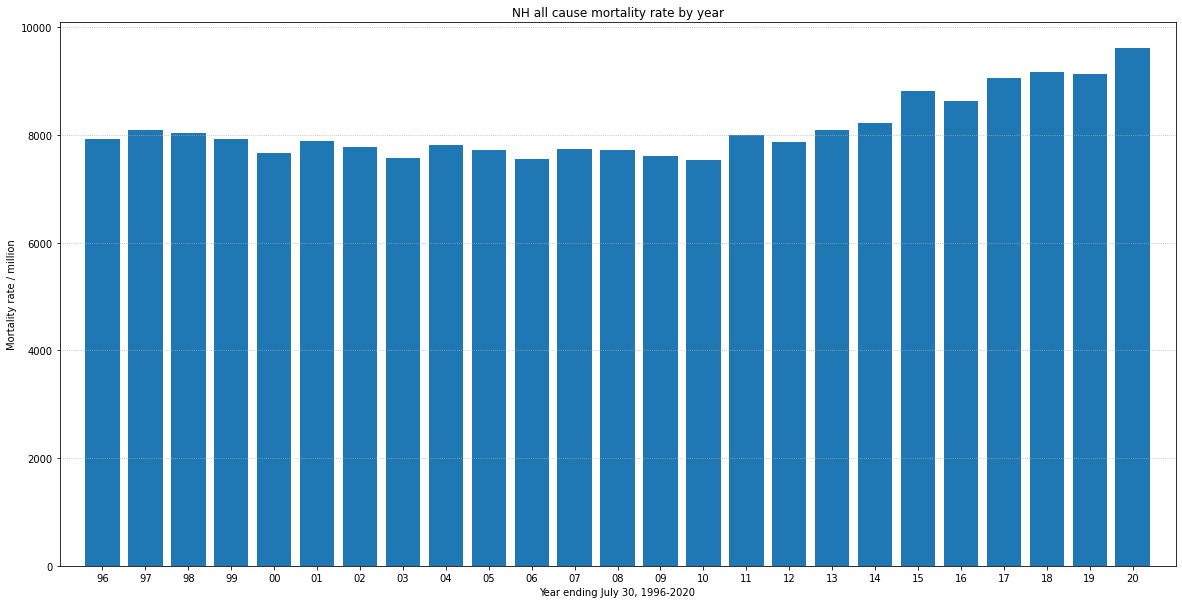

In [406]:
# Bar graph of annual mortality
x = np.linspace(1, mby.shape[0], mby.shape[0])
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(x, mby['Rate']*1000000)
ax.set_xlabel('Year ending July 30, 1996-2020')
ax.set_ylabel('Mortality rate / million')
ax.set_title('NH all cause mortality rate by year')
ax.set_xticks(range(1,26))
x = ax.set_xticklabels([f"{str(year+1)[2:]}" for year in range(1995, 2020)])
ax.grid(axis='y', linestyle='dotted')
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)
ax.set_xlim(right=26)

In [405]:
# Bar graph of annual mortality with trend line from 2009 to 2020
x = np.linspace(1, mby.shape[0], mby.shape[0])
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(x, mby['Rate']*1000000)
# Add fit line, then add envelope line (fit line lifted so everthing fits underneath)
ax.add_line(mpl.lines.Line2D(x, [None if not y else y*1000000 for y in line], label='Fitted line', color='red', linewidth=5))
#ax.add_line(mpl.lines.Line2D(x, env_line, label='Fitted line', color='red', linewidth=5, linestyle='dotted' ))
ax.set_xlabel('Year ending July 30, 1996-2020', fontsize=20)
ax.set_ylabel('Mortality rate / million', fontsize=20)
ax.set_title('NH all cause mortality by year', fontsize=20)
ax.set_xticks(range(1,26))
x = ax.set_xticklabels([f"{str(year+1)[2:]}" for year in range(1995, 2020)], fontsize=20)
y = ax.set_yticklabels([y for y in range (0, 10001, 2000)], fontsize=20)
ax.grid(axis='y', linestyle='dotted')
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)
ax.set_xlim(right=26)

/home/louis/.virtualenvs/nhwitness/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


(0.0, 26.0)

In [404]:
# Bar graph of change in deaths since prior year
x = np.linspace(1, perc.shape[0], perc.shape[0])
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(x, perc)
ax.set_xlabel('Year ending July 30, 1996-2020', fontsize=20)
ax.set_ylabel('% Change in mortality', fontsize=20)
ax.set_title('NH all cause mortality rate % change to prior year', fontsize=20)
ax.set_xticks(range(1,26))
x = ax.set_xticklabels([f"{str(year+1)[2:]}" for year in range(1995, 2020)], fontsize=20)
y = ax.set_yticklabels([y for y in range (-4, 8, 2)], fontsize=20)
ax.grid(axis='y', linestyle='dotted')
ax.set_xlim(left=0)
ax.set_xlim(right=26)

/home/louis/.virtualenvs/nhwitness/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


(0.0, 26.0)